In [1]:
import main
from main import StepResult, ElasticData, CalculationResult, print_history, run_lammps
import network
import matplotlib.pyplot as plt
import convert
import os
import lammps_scripts

In [2]:
def plot_opt_history(log_dir: str, log_file:str = "optimization_log.pkl"):
    opt_history = main.load_optimization_log(os.path.join(log_dir, log_file))
    Bs = [step.dG.bulk_modulus for step in opt_history]
    Gs = [step.dG.shear_modulus for step in opt_history]
    Ps = [step.dG.p_ratio for step in opt_history]
    Zs = [step.network.coordination_number for step in opt_history]
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
    axs[0].plot(Zs, Ps, label='P')
    axs[0].set_ylabel("Poisson's ratio")
    axs[0].set_xlabel("Z")
    axs[0].legend()
    axs[0].set_ylim(-0.2, 0.6)
    # P ratio graph
    # steps = [i+1 for i in range(len(opt_history))]
    # axs[1].plot(steps, Ps, label='P')
    # axs[1].set_xlabel("Step")
    # axs[1].legend()
    # Moduli graph
    axs[1].plot(Zs, Bs, label='B')
    axs[1].plot(Zs, Gs, label='G')
    axs[1].set_ylabel("Moduli")
    axs[1].set_xlabel("Z")
    axs[1].legend()
    plt.show()

    return opt_history

In [7]:
ex = network.Network.from_data_file("retry.lmp")
print(len(ex.bonds))
print(len(ex.angles))
ex.remove_bond(ex.bonds[0])
ex.angles = ex._compute_angles(ex.atoms, ex.box, energy=0.01)
ex.header.angles = len(ex.angles)
ex.header.angle_types = len(ex.angles)
print(len(ex.bonds))
print(len(ex.angles))

580
2996
579
2972


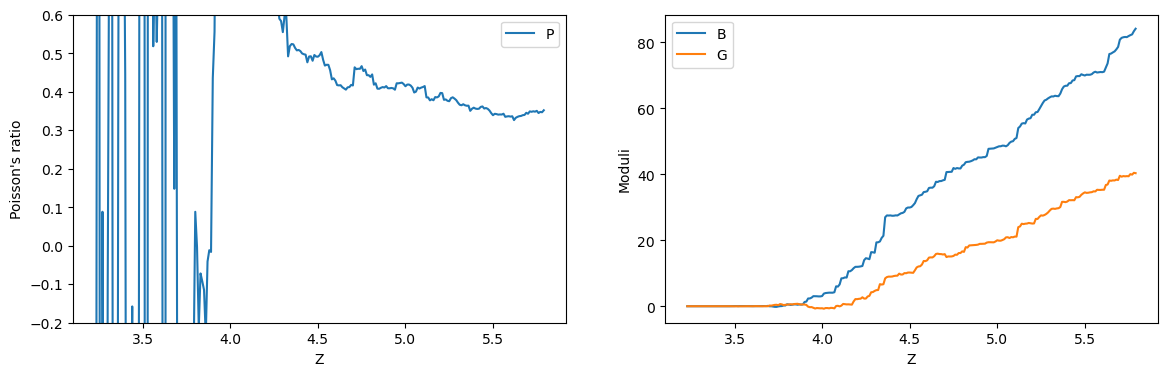

In [3]:
# orig_history = plot_opt_history("/home/sergey/work/auxetic_optimizer/successful_cases/", log_file="small_auxetic_0.01.pkl")
new_history = plot_opt_history("/home/sergey/work/data_tries/retry2/")
# old_network = history[0].network
# old_network.write_to_file("/home/sergey/work/auxetic_optimizer/successful_cases/step0_0.01.lmp")


In [ ]:
# orig_network = orig_history[0].network
print(new_history[-1].dG)
(1-new_history[-1].dG.shear_modulus/new_history[-1].dG.bulk_modulus)/(1+new_history[-1].dG.shear_modulus/new_history[-1].dG.bulk_modulus)

In [ ]:
new_network.bonds == orig_network.bonds

In [ ]:
print(orig_history[0])
print(new_history[0])

In [ ]:
history[-1].network.coordination_number

In [ ]:
# opt_dir = "/home/sergey/python/simulator_data_gen/data/raw/networks/90/0"
opt_dir = "networks/80/0"

opt_history = main.load_optimization_log(os.path.join(opt_dir, "optimization_log.pkl"))
# opt_history = main.load_optimization_log(os.path.join(opt_dir, "small_auxetic.pkl"))

steps = [i+1 for i in range(len(opt_history))]
Bs = [step.dG.bulk_modulus for step in opt_history]
Gs = [step.dG.shear_modulus for step in opt_history]
Ps = [step.dG.p_ratio for step in opt_history]
Zs = [step.network.coordination_number for step in opt_history]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))
# P ratio graph
axs[0].plot(Zs, Ps, label='P')
axs[0].set_ylabel("Poisson's ratio")
axs[0].set_xlabel("Z")
axs[0].legend()
# P ratio graph
axs[1].plot(steps, Ps, label='P')
axs[1].set_xlabel("Step")
axs[1].legend()
# Moduli graph
axs[2].plot(Zs, Bs, label='B')
axs[2].plot(Zs, Gs, label='G')
axs[2].set_ylabel("Moduli")
axs[2].set_xlabel("Z")
axs[2].legend()

plt.show()
